# Solving system of linear equations using Qiskit's HHL implementation

Works (tested) with 2x2 and 4x4 problems and few 3x3 problems.
Accuracy depends a lot on properties of a matrix.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.algorithms.linear_solvers.hhl import HHL
from qiskit.quantum_info import Statevector, Operator

import numpy as np


def is_symetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


def linalg_qsolve(A, b, verbose=False, print_qasm=False):
    matrix = A.copy()
    vector = b.copy()
    
    # rescale problem to log2
    if(np.log2(len(matrix)) < np.ceil(np.log2(len(matrix)))):
        while np.log2(len(matrix)) < np.ceil(np.log2(len(matrix))):
            matrix = np.vstack([matrix, np.zeros(len(matrix))])
            matrix = np.c_[ matrix, np.append(np.zeros(len(matrix) - 1), -1) ]

        while np.log2(len(vector)) < np.ceil(np.log2(len(vector))):
            vector = np.append(vector, [0])

    # check if input is hermitian
    if(not is_symetric(matrix)):
        # convert A to hermitian
        Z = np.zeros((len(matrix), len(matrix)))
        matrix = np.block([[Z, matrix], [matrix.T, Z]])

        # rescale b
        vector = np.append(np.zeros(len(vector)), vector)

    hhl_solution = HHL().solve(matrix, vector)
    
    state_vector = Statevector(hhl_solution.state).data
    
    num_qubits = hhl_solution.state.num_qubits
    offset = 2**(num_qubits - 1)
    x = []
    for index in range(len(vector)):
        x.append(state_vector[offset + index])

    x = np.real(x)
    
    x = hhl_solution.euclidean_norm * (x / np.linalg.norm(x))

    if(verbose):
        # Get classical solution (to compare with quantum solution)
        xc = np.linalg.solve(A, b)
        
        print("Classical solution:", xc)
        print("Quantum solution:  ", x)

        display(hhl_solution.state.draw(output="mpl"))

        """
        print("Raw state vector:", repr(np.round(state_vector, 8)), "\n")
        print("Raw output:", repr(np.round(list(state_vector[offset + index] for index in range(len(vector))), 8)), "\n")
        print("Euclidean norm:", hhl_solution.euclidean_norm, "\n")
        
        qc = hhl_solution.state
        for op_name in qc.count_ops():
            ins = qc.get_instructions(op_name)
            print("\n")
            print("***", op_name, "***")            
            op = ins[0][0]
            op_matrix = Operator(op).data
            qq = QuantumCircuit()
            qr = QuantumRegister(np.log2(len(op_matrix)))
            qq.add_register(qr)
            qq.append(op, [q for q in qr])
            try:
                print(qq.qasm())
            except:
                qq = transpile(qq, basis_gates=['id', 'u3', 'cx'])
                print(qq.qasm())

            print(repr(np.round(op_matrix, 8)))
        """

    if(print_qasm):
        transpiled = transpile(hhl_solution.state, basis_gates=['id', 'u3', 'cx'], optimization_level=3)
        print(transpiled.qasm())
        
    return x


# A few examples


*** Problem 1 ***

Classical solution: [1.125 0.375]
Quantum solution:   [1.125 0.375]


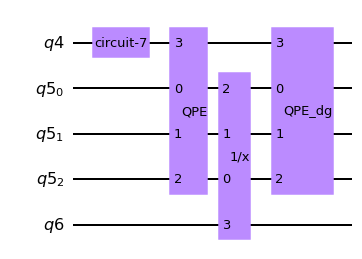




*** Problem 2 ***

Classical solution: [-0.13816128  0.39079884]
Quantum solution:   [-0.13761914  0.39134098]


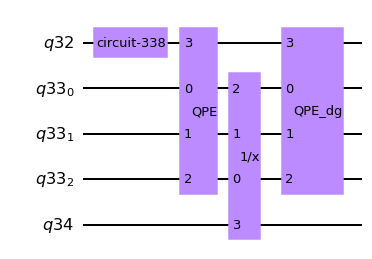




*** Problem 3 ***

Classical solution: [ 0.86023308 -1.48719142]
Quantum solution:   [ 0.87786206 -1.46956242]


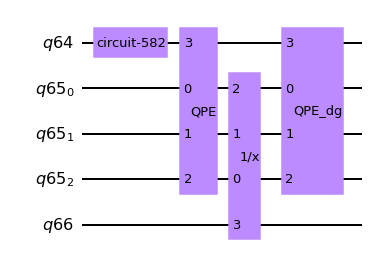




*** Problem 4 ***

Classical solution: [-0.00686554 -0.60915108]
Quantum solution:   [-0.01168517 -0.60433144]


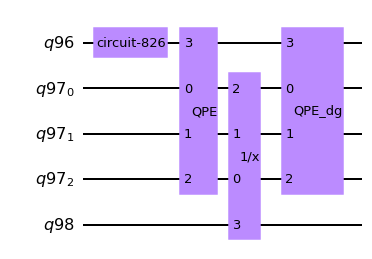




*** Problem 5 ***

Classical solution: [-0.03125  0.21875  0.34375  0.40625]
Quantum solution:   [-0.03125  0.21875  0.34375  0.40625]


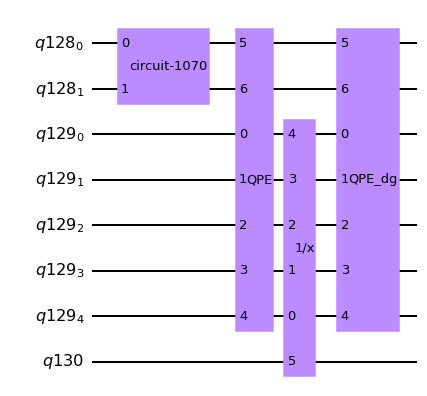

In [2]:
problems = [
    {
        "A": np.array([
            [ 1, -1/3 ],
            [ -1/3, 1 ]
        ]),

        "b": np.array([1, 0])
    },

    {
        "A": np.array([
            [ 2.97144841, 1.17569854],
            [ 1.17569854, 2.97144841]
        ]),

        "b": np.array([0.04892252, 0.99880258])        
    },

    {
        "A": np.array([
            [0.86540304, 0.35951908],
            [0.35951908, 0.86540304]
        ]),

        "b": np.array([ 0.20977463, -0.97774977])
    },

    {
        "A": np.array([
            [ 1.64120030,  -0.08631518 ],
            [-0.08631518,   1.64120030 ]
        ]),

        "b": np.array([ 0.04131126, -0.99914633])
    },

    {
        "A": np.array([
            [15,  9,  5, -3],
            [ 9, 15,  3, -5],
            [ 5,  3, 15, -9],
            [-3, -5, -9, 15]
        ]) * (1/4),

        "b": np.array([0.5, 0.5, 0.5, 0.5])
    }
]


for problem_index in range(len(problems)):
    print("\n*** Problem", str(problem_index + 1), "***\n")

    problem = problems[problem_index]

    x = linalg_qsolve(problem["A"], problem["b"], verbose=True, print_qasm=False)

    print("\n")
 